# Lasso regression on data smoothed with Gaussian (n = 10)

In [4]:
library(tidyverse)


library(glmnet)


Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16



In [2]:
sum_control_ATAC_bin_rm_gaussian_mean <- read.csv("../../data/sum_control_normalized_gaussian_smooth_ATAC_bin_rm.csv")
#sum_control_ATAC_bin_rm_gaussian_mean <- read.csv(snakemake@input[["input_train_data_std"]])

ATAC_val <- sum_control_ATAC_bin_rm_gaussian_mean %>% select(ATAC_val)
sum_control_ATAC_bin_rm_gaussian_mean = sum_control_ATAC_bin_rm_gaussian_mean %>% select(-ATAC_val)

head(sum_control_ATAC_bin_rm_gaussian_mean)

X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700
0,0,0,0,0,0,1.295662e-06,1.315240e-06,1.377055e-06,1.493326e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0
0,0,0,0,0,0,1.898063e-06,2.292049e-06,2.673739e-06,2.929634e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0
0,0,0,0,0,0,1.114137e-06,1.158812e-06,1.143512e-06,1.142800e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0
0,0,0,0,0,0,8.292440e-07,8.302439e-07,8.203466e-07,8.455300e-07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0
0,0,0,0,0,0,6.358502e-07,7.854683e-07,1.037024e-06,1.299074e-06,...,1.429406e-07,1.337957e-07,1.097238e-07,7.883745e-08,4.962914e-08,0,0,0,0,0
0,0,0,0,0,0,1.369131e-06,1.302297e-06,1.181740e-06,1.057154e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0


## Finding the best lambda

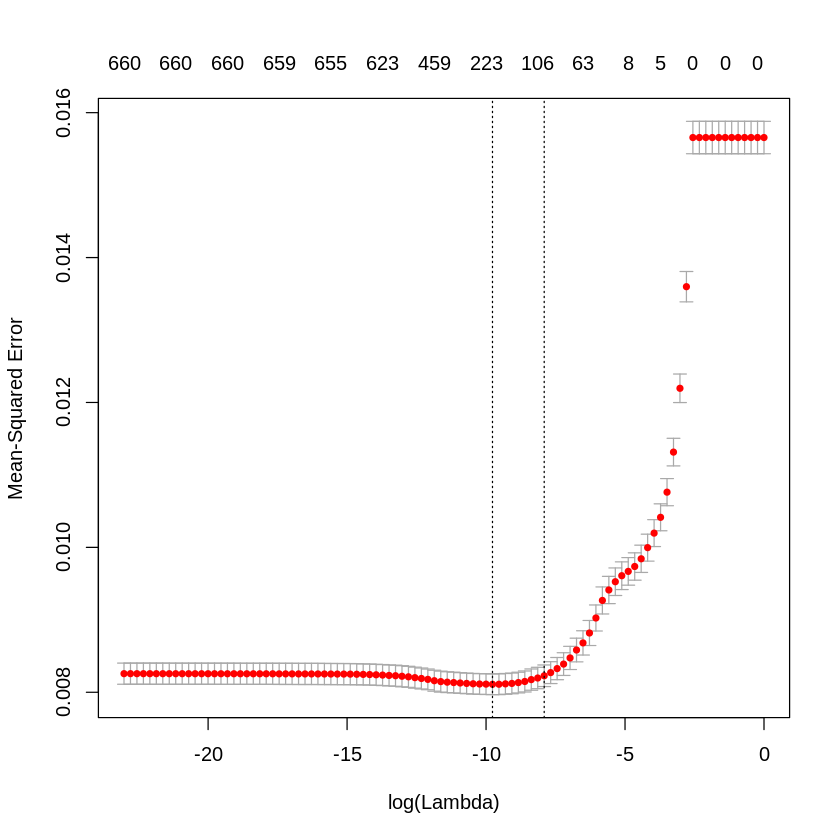

In [5]:
set.seed(0)
#X==predictor
#y==response
#sum_control_ATAC_bin_rm <- sum_control_ATAC  %>% dplyr::select(-bin)

y <- ATAC_val %>% as.matrix()
X <- sum_control_ATAC_bin_rm_gaussian_mean %>% as.matrix()
#head(X)

lambdas_to_try <- 10^seq(-10, 0, length.out = 100)
#standardize = FALSE -- range -12, -3
#standardize = TRUE -- range -10, 0

lasso_smooth_cv <- cv.glmnet(X, y, alpha = 1, lambda = lambdas_to_try,
                      standardize = TRUE, nfolds = 10)

#Plotting the MSE and log(lambda)

plot(lasso_smooth_cv)

In [6]:
(lambda_smooth_cv <- lasso_smooth_cv$lambda.min)

[1] 5.722368e-05

In [9]:
CV_lasso_smooth<-function(data, nfolds){
    set.seed(0)
    cvfolds <- cut(1:nrow(data), breaks = nfolds, labels = F)
    cvfolds <- sample(cvfolds)
    

    predicted <- rep(NA, nrow(data))
    #data_as_matrix <- data %>% dplyr::select(-ATAC_val) %>% as.matrix() 
    
    y <- ATAC_val %>%  as.matrix()
    X <- sum_control_ATAC_bin_rm_gaussian_mean %>% as.matrix()
    
    for (i in 1:nfolds){
        rows      <- which(cvfolds==i)
        testdata  <- X[rows,]
        traindata <- X[-rows,]
        train_y <- y[-rows,]

        fit       <- glmnet(traindata, train_y, alpha = 1, lambda = lambda_smooth_cv, standardize = TRUE)
        tmp       <- predict(fit, s=lambda_smooth_cv, testdata)
        predicted[rows] <- tmp
    }
    
    rm(tmp)
    observed <- y
    head(observed)
    mean(observed)
    se    <- (observed-predicted)^2
    mse   <- mean(se)
    (rmse <- sqrt(mse))
    
    return(tibble(observed = observed, predicted = predicted))
}

In [10]:
res_lasso_smooth_gaussian_pred <- CV_lasso_smooth(sum_control_ATAC_bin_rm_gaussian_mean, 10)

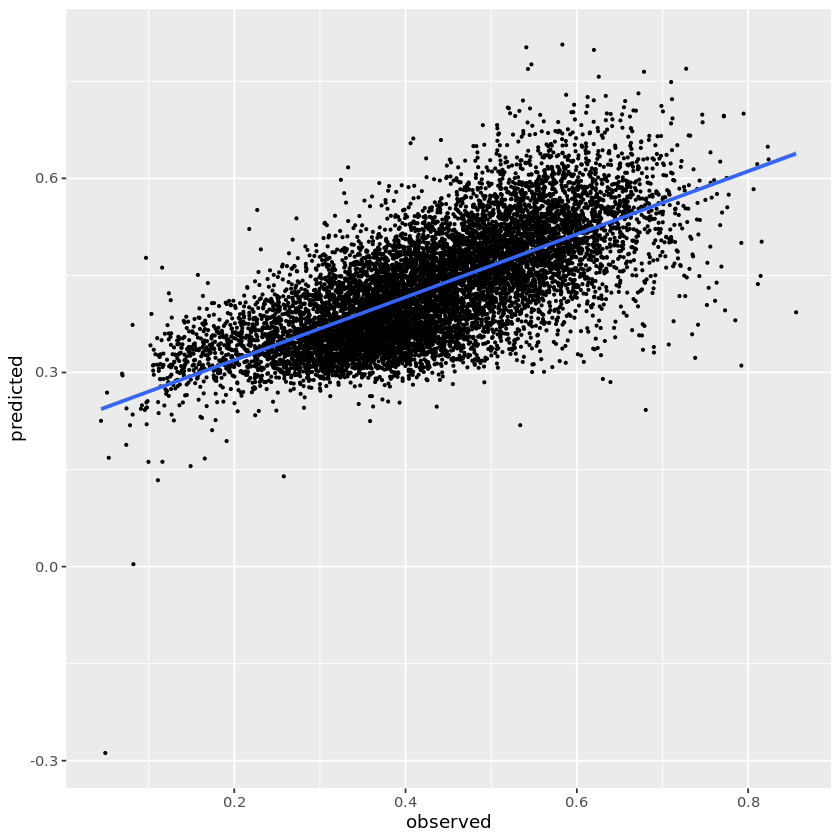

In [11]:
ggplot(res_lasso_smooth_gaussian_pred, aes(x = observed, y = predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [12]:
cor(res_lasso_smooth_gaussian_pred$observed, res_lasso_smooth_gaussian_pred$predicted)

# Standardize = TRUE: ATAC_val 0.6947938s
# Standardize = FALSE: ATAC_val 0.6962595

ATAC_val,0.6947938


In [13]:
y <- ATAC_val %>% as.matrix()
X <- sum_control_ATAC_bin_rm_gaussian_mean %>% as.matrix()

fit       <- glmnet(X, y, alpha = 1, lambda = lambda_smooth_cv, standardize = TRUE)
saveRDS(fit, snakemake@output[["output_model"]])
#tmp       <- predict(fit, s=lambda_smooth_cv, testdata)


## Predict on normalized smoothed samples

In [7]:
## read in the model

fit <- readRDS("../../Trained_models/On_summed_controls/Lasso_models/lasso_std_TRUE_gaussian.rds")

In [8]:
filename =  "../../data/all_samples_normalized_gaussian_smooth_NEW.csv"
#filename = snakemake@input[["input_test_data_std"]]

In [9]:
small_test <- read_csv(file = filename, col_names = T, comment = "#", skip = 0, n_max = 20)
head(small_test)

Parsed with column specification:
cols(
  .default = col_double(),
  sample = col_character(),
  bin = col_character()
)
See spec(...) for full column specifications.


sample,bin,X30,X31,X32,X33,X34,X35,X36,X37,...,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700
PGDX10344P1,chr10_400,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_402,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PGDX10344P1,chr10_403,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
cols_predictions = as.data.frame(t(c("sample", "bin", "ATAC_prediction")))
cols_predictions

V1,V2,V3
sample,bin,ATAC_prediction


In [11]:
# Initiate the empty file and add column names

output_filename = "../../data/ATAC_predictions_on_all_samples_NEW/ATAC_pred_lasso_std_TRUE_gaussian.csv"

write.table(NULL, file=output_filename, 
             append = F, 
             sep=',', 
             row.names=F, 
             col.names=F)

write.table(cols_predictions, output_filename, append = F, sep=',', col.names=F, row.names=F)

In [12]:
f <- function(df1, pos) {
    df1[3:673] <- lapply(df1[3:673], as.numeric)
    
    df <- df1 %>% select(-c("sample", "bin")) %>% as.matrix()
    tmp       <- as.vector(predict(fit, s=lambda_smooth_cv, df))
    
    tmp <- tibble(sample = df1$sample, bin = df1$bin, ATAC_prediction = tmp)
    #message(tmp)
    write.table(tmp, output_filename, append = TRUE, sep=',', col.names=F, row.names=F)

}

df <- read_delim_chunked(file = filename, 
                 callback = DataFrameCallback$new(f), 
                 chunk_size = 10000, col_names = T,
                 delim = ",", 
                 progress = show_progress())


Parsed with column specification:
cols(
  .default = col_double(),
  sample = col_character(),
  bin = col_character()
)
See spec(...) for full column specifications.
